<a href="https://colab.research.google.com/github/Idelsohn/Real-world-application/blob/main/first_project_EDA_PREPROCSSING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


### Sklearn libraries
from sklearn.preprocessing import LabelEncoder
# Encoders
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
# Feature selection
from sklearn.feature_selection import mutual_info_classif


!pip install catboost
#################### Models
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression

#################### Actions
from sklearn import set_config
import os
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedKFold

#
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
RANDOM_STATE = 42
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from sklearn.metrics import  confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import f1_score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Configuration
Run This Action one to convert the xlsx file into a csv file

In [ ]:
# Specify Path
BASE_PATH_EXCEL = "/content/sample_data/Project Intake database 03062024.xlsx"

# Read the excel file
xlsx_data = pd.read_excel(BASE_PATH_EXCEL, sheet_name=None)

# Iterate through the sheets
for sheet_name, df in xlsx_data.items():
    # Save each sheet as a separate CSV file
    df.to_csv(f'{sheet_name}.csv', index=False)

### *Configuration values*
We set some key values and set the dataframe

In [ ]:
#Specify Details
BASE_PATH = '/content/Project Intake Sheet.csv'
columns = ['Support Request Support Request ID','Request Status','Regional Parent Name','Country Name',
           'Probability (%)','Vertical','Category ','Required Support', 'Last 4Q Margin ',
           'Last 4Q Revenue', 'Account name lookup ','Solution Complexity',
           'Solution Priority','Product(s)','Customization Type', 'Estimated Revenue Max (Millions)',
           'Estimated Margin (%)','Ship To Countries']

#Read the file
data = pd.read_csv(BASE_PATH)

#Adjust the final to contain only the selected columns
data = data[columns]

# Filtering the data to contain only Cancelled and
TARGET = 'Request Status'

# Find Different columns
I had to develop a function to find the different columns between two CSV files.

In [ ]:
# # Specify Path
# BASE_PATH_EXCEL = "/content/sample_data/Prediction base 03042024.xlsx"

# # Read the excel file
# xlsx_data = pd.read_excel(BASE_PATH_EXCEL, sheet_name=None)

# # Iterate through the sheets
# for sheet_name, df in xlsx_data.items():
#     # Save each sheet as a separate CSV file
#     df.to_csv(f'{sheet_name}2.csv', index=False)



In [ ]:
# BASE_PATH_2 = '/content/Project Intake Sheet2.csv'
# data_1 = pd.read_csv(BASE_PATH)
# data_2 = pd.read_csv(BASE_PATH_2)
# import pandas as pd

# # Columns unique to df1
# unique_cols_df1 = set(data_1.columns) - set(data_2.columns)
# print("Columns unique to file1.csv:", unique_cols_df1)

# # Columns unique to df2
# unique_cols_df2 = set(data_2.columns) - set(data_1.columns)
# print("Columns unique to file2.csv:", unique_cols_df2)


# **Preprocessing**
In this Section I will perform actions that start to prepare the data for

In [ ]:
# Table for first look
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing#'] = df.isna().sum()
    sum['missing%'] = (df.isna().sum())/len(df)
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values
    return sum

summary(data).style.background_gradient(cmap='Blues')


,dtypes,missing#,missing%,uniques,count
Support Request Support Request ID,object,0,0.000000,2888,2894
Request Status,object,0,0.000000,14,2894
Regional Parent Name,object,0,0.000000,4,2894
Country Name,object,0,0.000000,52,2894
Probability (%),object,54,0.018659,856,2840
Vertical,object,0,0.000000,16,2894
Category,object,0,0.000000,7,2894
Required Support,object,0,0.000000,66,2894
Last 4Q Margin,float64,0,0.000000,681,2894
Last 4Q Revenue,float64,0,0.000000,681,2894


In [ ]:
num_cols = data.select_dtypes(include=['float'])

num_cols.describe().T\
    .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
    .background_gradient(subset=['std'], cmap='Blues')\
    .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
Last 4Q Margin,2894.000000,2668960.659603,12480821.599877,-2289058.740000,0.000000,151850.885000,1099591.600000,193471107.590000
Last 4Q Revenue,2894.000000,12174196.522702,42087609.663366,-332170.000000,0.000000,1389611.700000,7871820.600000,727180841.870000
Estimated Revenue Max (Millions),2893.000000,15.244765,62.951946,-0.500000,0.800000,2.000000,7.000000,999.000000
Estimated Margin (%),922.000000,0.160552,0.091751,-0.200000,0.100000,0.150000,0.200000,0.536000


### *Transform Y column*
This function is used to remove all the unecessary rows for the classification

In [ ]:
# Transform the Target column (This is the column we predicting on)

# define base values
Filter_list = ['Closed', 'Complete', 'Cancelled']
switch_str = 'Closed'
switcher_str = 'Complete'

# Transform
data = data.loc[data[TARGET].isin(Filter_list)]
data[TARGET] =data[TARGET].replace(switch_str, switcher_str)

<ipython-input-8-556adb5a61d7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[TARGET] =data[TARGET].replace(switch_str, switcher_str)


## ***Deal with columns***
our data is not the most polished with some columns having more than 500 different categories.
To solve that I came up with a few possiblities

### Problematic Columns
I will be dealing with the following columns

1.   Probability (%)
2.   Request Status
3.   Support Request Support Request ID



In [ ]:
# 1 - Probability (%) - convert everything cell that isn't a number type to nan
data['Probability (%)'] = data['Probability (%)'].str.replace('%', '')
data['Probability (%)'] = pd.to_numeric(data['Probability (%)'], errors='coerce')

# 2 - Request Status - convert it to 0 and 1 for the classification (Because it the Target data)
target_encoder = {
    'Cancelled':1,
    'Complete':0}
def transform_target_column(col):
    col = col.map(target_encoder)
    return col

data[TARGET] = transform_target_column(data[TARGET])

# 3 - Support Request Support Request ID - remove this id column
print(data.shape)
data = data.drop(columns = 'Support Request Support Request ID')
data.shape

(1622, 18)


<ipython-input-9-deef09dbfe03>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Probability (%)'] = data['Probability (%)'].str.replace('%', '')
<ipython-input-9-deef09dbfe03>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Probability (%)'] = pd.to_numeric(data['Probability (%)'], errors='coerce')
<ipython-input-9-deef09dbfe03>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

(1622, 17)

## Encoding options
to encode the object type data (because float type is already fit to go machine learning process) after we processed it we can use following options option

### *1. Keep top 10 labels*
In our dataframe there are columns with dozens and even hunders of unique labels. It will be impossible and uneffective to the computer to deal with. The following function solves the problem by narrowing each column to have only the top 10 lables there and the rest will be regarded as others.

Of course the 10 labels is only for the baseline and I will experiment with different amount of labels too.





In [ ]:
# cols = data.columns
# for col in cols:
#     value_counts = data[col].value_counts(dropna = False)
#     top_10_labels = value_counts.index[~value_counts.index.isna()][:10].tolist()
#     mask = (data[col].notna()) & (~data[col].isin(top_10_labels))
#     data.loc[mask, col] = "Others"

# print(data)

## *2. Get Dummies*
converts every unique value in the column selected into a column of his own

In [ ]:
dummies_columns = ['Regional Parent Name', 'Category ', 'Vertical', 'Solution Complexity', 'Solution Priority']
data = pd.get_dummies(data, columns = dummies_columns)


## *3. Frequency Encoding*
a method where you replace every category with the amount of times it appears. For example the color "blue" comes up twice in the color column then the cells that contain this word will be replaced by 2

In [ ]:
cat_cols = data.select_dtypes(exclude=[np.number])

for col in cat_cols:
  freq = data[col].value_counts() # Calculate frequencies

  # Replace original values with frequencies
  data[col] = data[col].map(freq)

## 4. Fill Nan's
to predict with lower level algorithms there is a need to eliminate Nan's from the dataframe

In [ ]:
data = data.fillna(-1)

In [ ]:
# export the processed dataframe
data.to_csv('Project_Intake_Sheet.csv', index=False)

# **EDA** - Exploratory Data Analysis

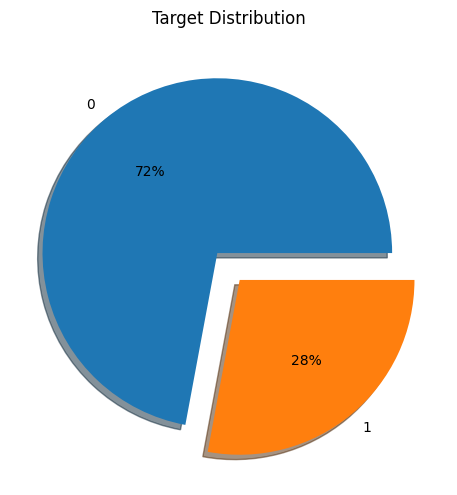

In [ ]:
fig, axs = plt.subplots(figsize = (12,5))
plt.suptitle("Target Distribution")

axs.pie(
        data[TARGET].value_counts(),
        shadow = True,
        explode=[.1 for i in range(data[TARGET].nunique())],
        labels = data[TARGET].value_counts().index,
        autopct='%1.f%%',
    )

plt.tight_layout()
plt.show()

In [ ]:
# def corr_heat_map(df,scale=1) :
#     # Calculate the correlation matrix
#     correlation_matrix = df.corr()

#     # Create a mask for the upper triangle
#     mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

#     # Set up the matplotlib figure
#     plt.figure(figsize=(10//scale, 8//scale))

#     # Define a custom color palette
#     cmap = sns.diverging_palette(220, 20, as_cmap=True)

#     # Draw the heatmap with the mask and correct aspect ratio
#     sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
#                 square=True, linewidths=.5, cbar_kws={"shrink": 0.7})

#     plt.title('Correlation Heatmap')

# plt.figure(figsize=(20,7))

# corr_heat_map(data)
# plt.show()
correlation = data.corr(method = 'pearson').abs()
sorted_features = correlation['Request Status'].sort_values(ascending=False)
sorted_features.head(20)


,Request Status
Request Status,1.000000
Solution Complexity_Tier 3,0.176674
Solution Complexity_Tier 2,0.164676
Regional Parent Name_EMEA,0.111089
Category _label,0.094166
Required Support,0.082153
Category _other,0.071140
Regional Parent Name_APJ,0.069774
Solution Priority_High,0.061283
Regional Parent Name_AMER,0.057547


# Adversarial Validation
Adversarial Validation is a very clever and very simple way to let us know if our test data and our training data are similar

In [ ]:
# Configuration
# target_col = data[TARGET]
# train = data.drop(columns = [TARGET])
# X_train, X_temp, y_train, y_temp = train_test_split(train, target_col, test_size=0.3, random_state=RANDOM_STATE, stratify=target_col)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=RANDOM_STATE, stratify=y_temp)
# print(X_train.shape)
# print(X_val.shape)
# print(X_test.shape)
# print(y_train.value_counts())
# print(y_test.value_counts())

# Configuration
target_col = data[TARGET]
train = data.drop(columns = [TARGET])
X_train, X_test, y_train, y_test = train_test_split(train, target_col, test_size=0.2, random_state=RANDOM_STATE, stratify=target_col)
print(X_train.shape)
print(X_test.shape)

(1297, 45)
(325, 45)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

X =  pd.concat([X_train, X_test], axis=0)
y = [0] * len(X_train) + [1] * len(X_test)

model = XGBClassifier(random_state=RANDOM_STATE)
cv_preds = cross_val_predict(model, X, y, cv=5, n_jobs=-1, method='predict_proba')

score = roc_auc_score(y_true=y, y_score=cv_preds[:,1])
print(f"roc-auc score: {score:0.3f}")

roc-auc score: 0.539


Since the roc-auc score is about 0.5, we have a confirmation that train and test are from the same distribution

# **Baseline** - creating a deafult baseline model
Created two baselines -

1)  an estimation of f1 score across different models

2) LGBM model with no hyperparameter tuning but with class weights

In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
classifiers = [
    CatBoostClassifier(verbose = False),
    LGBMClassifier(),
    XGBClassifier(),
    DecisionTreeClassifier()
]
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train,
        scoring = "f1", cv = cv, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({
    "CrossValMeans":cv_means,
    "CrossValerrors": cv_std,
    "Algorithm":["CatBoostClassifier", "LGBMClassifier", "XGBClassifier", "DecisionTreeClassifier"]
})

cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.239312,0.088935,CatBoostClassifier
1,0.320786,0.090153,LGBMClassifier
2,0.318145,0.061606,XGBClassifier
3,0.368600,0.062167,DecisionTreeClassifier


### Decision Tree Classifier visualization
Present the Decision Tree to the costumer in order to understand  

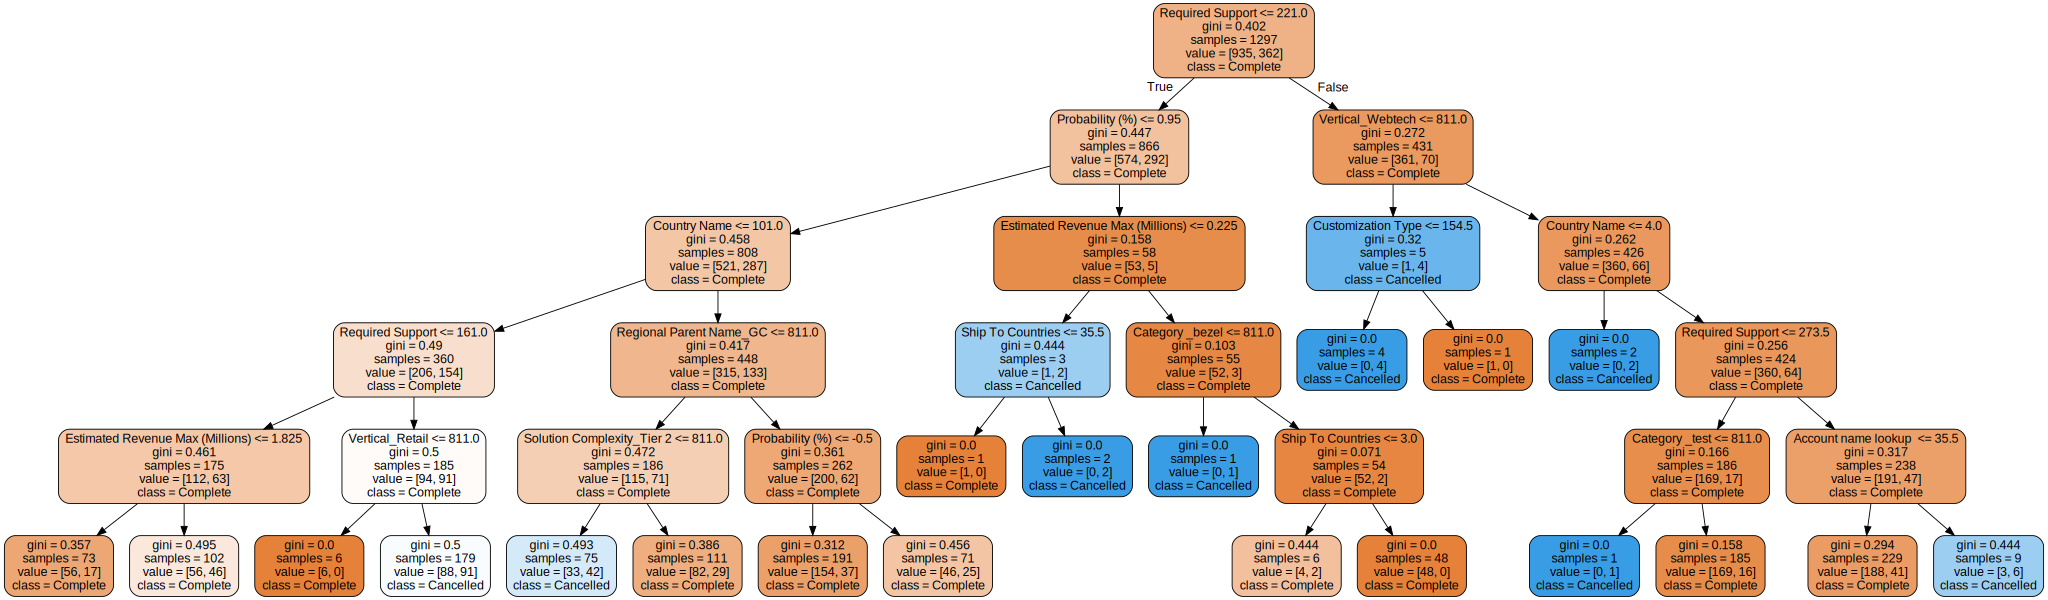

In [ ]:
from sklearn import tree
from sklearn.datasets import load_iris
import graphviz

# 2. Fit Decision Tree
clf = tree.DecisionTreeClassifier(max_depth=5)  # Control tree depth for readability
model = clf.fit(X_train, y_train)


# 3. Render Visualization using graphviz
dot_data = tree.export_graphviz(model, out_file=None,
                                feature_names=X_train.columns,
                                class_names=['Complete','Cancelled'],
                                filled=True, rounded=True)
graph = graphviz.Source(dot_data)

# 4. Display or Save
graph.render("iris_tree")  # Creates a file named "iris_tree.pdf"
# OR to display inline
graph

F1-Score: 0.43870967741935485


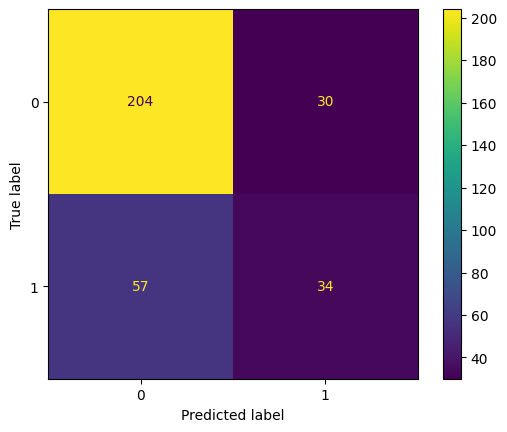

In [ ]:
y_pred = model.predict(X_test)
# Calculate the F1-score
f1 = f1_score(y_true=y_test, y_pred=y_pred)  # Assuming you have class imbalance

print("F1-Score:", f1)

cm_ensemble = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble)
disp.plot()
plt.show()

### **Shap Values**
use shap value in order to estimate the project

In [ ]:
!pip install shap
import shap

# Explain predictions on a subset of test data (X_test_subset)
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)

import shap

model = model

explainer = shap.TreeExplainer(model, feature_perturbation='interventional')
#interventional argument breaks feature dependencies and provides better estimate

#It takes time just take some sample
test_explain = X_val.sample(n=1000, random_state=random_state)

shap_values = explainer.shap_values(test_explain, check_additivity=False )

# Summary plot of feature importance
shap.summary_plot(shap_values, test_explain, max_display = len(X_val) )

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.4 MB/s eta 0:00:00


NameError: name 'X_val' is not defined

In [ ]:
from sklearn.datasets import make_classification
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report

# 1. Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

# 2. Create and train the model with class weights
model = LGBMClassifier(class_weight=class_weights_dict ,random_state=42, verbose = -1)
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
cm_ensemble = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble)
disp.plot()
plt.show()



In [ ]:
def plot_feature_importance(model, feature_names=None, top_n=20, plot=True):

    # Get feature importance
    feature_importance = model.feature_importances_

    # Get feature names
    if feature_names is None:
        feature_names = model.feature_name()

    # Create DataFrame with feature names and importance scores
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

    # Sort by importance and select top features
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(top_n)

    # Plot the feature importance
    if plot:
        plt.figure(figsize=(10, 10))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
        plt.title('LightGBM Feature Importance')
        plt.show()

    return feature_importance_df

feature_importance_df = plot_feature_importance(model,feature_names=X_train.columns)

In [ ]:
from ipywidgets import interact, FloatSlider


fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

# Calculate the Youden Index for each threshold
youden_index = tpr - fpr
optimal_threshold = thresholds[np.argmax(youden_index)]
max_youden_index = np.max(youden_index)

print(f"Optimal threshold: {optimal_threshold}")
print(f"Maximum Youden Index: {max_youden_index}")

# Function to update the confusion matrix based on the selected threshold
def update_confusion_matrix(threshold):
    # Apply the threshold to get binary predictions
    final_preds = (y_pred_prob >= threshold).astype(int)
    cm = confusion_matrix(y_val, final_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix at threshold = {threshold:.2f}')
    plt.show()

# Plot ROC curve and Youden Index
plt.figure(figsize=(10, 5))

# Subplot 1: ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Subplot 2: Youden Index
plt.subplot(1, 2, 2)
plt.plot(thresholds, youden_index, label='Youden Index')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal threshold = {optimal_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Youden Index')
plt.title('Youden Index vs Threshold')
plt.legend()

plt.tight_layout()
plt.show()

#Playing with slider bar
interact(update_confusion_matrix, threshold=FloatSlider(value=optimal_threshold, min=0.0, max=1.0, step=0.01))
d = {optimal_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Youden Index')
plt.title('Youden Index vs Threshold')
plt.legend()

plt.tight_layout()
plt.show()

#Playing with slider bar
interact(update_confusion_matrix, threshold=FloatSlider(value=optimal_threshold, min=0.0, max=1.0, step=0.01))

In [ ]:
# 5. Evaluation with emphasis on the minority class
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

y_pred = model.predict(X_val)

print('Accuracy:', accuracy_score(y_val, y_pred))
print('Recall:', recall_score(y_val, y_pred))
print('Precision:', precision_score(y_val, y_pred))
print('F1-Score:', f1_score(y_val, y_pred))


cm_ensemble = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble)
disp.plot()
plt.show()

# Optuna and modeling

# Imports for Modeling and HyperTuning

In [ ]:
!pip install optuna
import optuna
import lightgbm as lgb
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score  # Or other suitable metric

def objective_lgbm(trial):
    params = {

        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_float('learning_rate', 0.3, 1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 0.1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-1, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
    }
    lgbParams = {
        'is_unbalance': True,
        'random_state': 42,
        'metric': 'binary_logloss', # binary metric
        "boosting_type": "gbdt", # Can experiment with other types
        'objective': 'binary', # For binary classification
    }

    LGBM_model = lgb.LGBMClassifier(**params, **lgbParams)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_validate(LGBM_model, X_train, y_train, cv=cv, scoring='f1', return_train_score=False)

    score = cv_results['test_score'].mean()
    return score

# Assuming you have your data in 'X_train' and 'y_train'

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective_lgbm, n_trials=50)

best_params = study.best_params
print("Best Hyperparameters for LGBM:", best_params)

optuna.visualization.plot_param_importances(study)


In [ ]:
optuna_LGBM = {
               'max_depth': 13,
               'num_leaves': 147,
               'learning_rate': 0.4500756157117973,
               'feature_fraction': 0.7301992104097964,
               'bagging_fraction': 0.9359450585018844,
               'bagging_freq': 6, 'reg_alpha': 0.018888660125774434,
               'reg_lambda': 0.1399392554580834,
               'colsample_bytree': 0.7185635561648196,
               'subsample': 0.9130070661805147,
               'min_child_samples': 23
               }
lgbm_model = LGBMClassifier(**optuna_LGBM)
lgbm_model.fit(X_train, y_train)

y_pred = model.predict(X_val)

print('Accuracy:', accuracy_score(y_val, y_pred))
print('Recall:', recall_score(y_val, y_pred))
print('Precision:', precision_score(y_val, y_pred))
print('F1-Score:', f1_score(y_val, y_pred))


cm_ensemble = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble)
disp.plot()
plt.show()

# XGBoost Optuna

In [ ]:
#!pip install optuna
import optuna
import lightgbm as lgb
from sklearn.model_selection import cross_validate

def objective_lgbm(trial, data, target):
    param = {
        "objective": "binary",  # Explicitly set binary objective
        "metric": "auc",  # Good for binary classification (other options listed below)
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
    }

    model = lgb.LGBMClassifier(**param)

    cv_results = cross_validate(model, data, target, cv=5, scoring='roc_auc',
                                return_train_score=False)

    return cv_results['test_score'].mean()

# Assuming you have your data in 'X_train' and 'y_train'
study = optuna.create_study(direction='maximize')  # Maximize AUC
study.optimize(lambda trial: objective_lgbm(trial, X_train, y_train), n_trials=100)

best_params = study.best_params
print("Best Hyperparameters for LGBM:", best_params)



In [ ]:
XGBoost_params_optuna = {
    'max_depth': 8,
    'min_child_weight': 5,
    'learning_rate': 0.37121407880565305,
    'n_estimators': 595,
    'subsample': 0.011992467193061185,
    'colsample_bytree': 0.618905962813888,
    'random_state': 42,
    'verbose': False
}

xgb = XGBClassifier(**XGBoost_params_optuna)

xgb.fit(X_train, y_train)
prediction = xgb.predict(X_test)

cm_ensemble = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble)
disp.plot()
plt.show()